# 1. Data Preparation

To simulate realistic loan application scenarios, we will create a synthetic dataset. 

Although using real-world data would provide the most accurate insights, synthetic data offers a valuable alternative for demonstration and educational purposes. Realistic datasets are available on platforms like Kaggle, but these are often sanitized and stripped of context, with prevalent solutions that may not be ideal for an original demonstration like ours.

We generate the synthetic dataset in four steps: 
1. Define key features and their distributions based on explicit assumptions (with particularly heavy reliance on GenAI)
2. Generate feature values independently according to their assumed distributions
3. Introduce correlations between the default rate and key features by setting the default risk for each data point as a function of several key features. 
4. Introduce randomness to the default rate

# 1.1 Defining key features and their distribution assumptions

Without access to expert interviews and real data, we first ask OpenAI's GPT-4 to create explicit mean/mode and skewness assumptions for each feature based on reputable organizations such as Statistics Finland and the Bank of Finland. 

The synthetic dataset will include key features typically assessed in loan default models: Income, Loan_Amount, Credit_Score, Employment_Status, Debt_to_Income, Loan_Term, Age, Home_Ownership, and Default.

There remains a risk of hallucination or inaccuracies inherent to AI-generated content. For our demonstration exercise, we will accept a quick inspection, and leave more detailed expert verifications as a further improvement point.

For real-life applications, it is crucial to perform extensive due diligence, including consulting multiple data sources and validating all assumptions. This synthetic dataset is intended solely for illustrative purposes and should not replace real financial data in professional decision-making.

Below is a table summarizing the assumptions used for generating each feature in our dataset:


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import lognorm, norm, beta, truncnorm
from sklearn.preprocessing import MinMaxScaler



# Creating the metadata DataFrame
metadata = {
    'Feature': [
        'Income', 
        'Loan_Amount', 
        'Credit_Score', 
        'Employment_Status', 
        'Debt_to_Income', 
        'Loan_Term', 
        'Age', 
        'Home_Ownership', 
        'Default'
    ],
    'Skewness Description': [
        'Positively skewed. Higher concentration of individuals with lower incomes, with fewer high-income earners.',
        'Positively skewed. Loan amounts are concentrated towards lower to moderate values, with fewer large loan amounts.',
        'Negatively skewed. Most people have good to excellent credit scores, with fewer individuals having very low credit scores.',
        'Binary distribution. Higher proportion of the population being employed, heavily weighted towards employment.',
        'Positively skewed. More individuals with lower ratios, but significant instances of high debt relative to income.',
        'Discrete uniform. Distributed across specific intervals with peaks at common loan terms like 20 and 30 years.',
        'Approximately normal. Centered around peak working ages (30-45 years), with fewer young and old applicants.',
        'Binary distribution. Higher proportion of the population owning homes, heavily weighted towards ownership.',
        'Positively skewed. Default rates are typically low, with a small percentage representing defaults.'
    ],
    'Mean/Mode Assumptions and Distribution Details': [
        'Mean: €4000, Distribution: Log-normal with σ = 0.5',
        'Mean: €175,000, Distribution: Log-normal with σ = 0.5',
        'Mean: 700, Mode: 750, Distribution: Normal (reversed) with μ = 100 and σ = 50',
        'Mode: Employed, Distribution: Binary with p = 0.9',
        'Mean: 0.6, Distribution: Beta (α = 2, β = 5) scaled to [0, 1.2]',
        'Mode: 20 years, Distribution: Discrete with p = [0.1, 0.2, 0.3, 0.1, 0.3]',
        'Mean: 35, Distribution: Normal with μ = 35 and σ = 10, clipped to [18, 75]',
        'Mode: Own, Distribution: Binary with p = 0.7',
        'Mean: 0.15, Distribution: Top 15% of risk scores' # Seems high for Finland, but we keep high since we lack other features. 
    ]
}

# Creating Metadata DataFrame
metadata_df = pd.DataFrame(metadata)

# Displaying the Metadata DataFrame
metadata_df


,Feature,Skewness Description,Mean/Mode Assumptions and Distribution Details
0,Income,Positively skewed. Higher concentration of ind...,"Mean: €4000, Distribution: Log-normal with σ =..."
1,Loan_Amount,Positively skewed. Loan amounts are concentrat...,"Mean: €175,000, Distribution: Log-normal with ..."
2,Credit_Score,Negatively skewed. Most people have good to ex...,"Mean: 700, Mode: 750, Distribution: Normal (re..."
3,Employment_Status,Binary distribution. Higher proportion of the ...,"Mode: Employed, Distribution: Binary with p = 0.9"
4,Debt_to_Income,Positively skewed. More individuals with lower...,"Mean: 0.6, Distribution: Beta (α = 2, β = 5) s..."
5,Loan_Term,Discrete uniform. Distributed across specific ...,"Mode: 20 years, Distribution: Discrete with p ..."
6,Age,Approximately normal. Centered around peak wor...,"Mean: 35, Distribution: Normal with μ = 35 and..."
7,Home_Ownership,Binary distribution. Higher proportion of the ...,"Mode: Own, Distribution: Binary with p = 0.7"
8,Default,Positively skewed. Default rates are typically...,"Mean: 0.15, Distribution: Top 15% of risk scores"


For Default Rate, we note that a rate of 15% is likely too high for Finland. However, given the constraints of our synthetic dataset, such as limited features and minimal feature engineering, we have adopted a heightened default rate to ensure sufficient variability and signal strength for our predictive models. Alternatively, we might assume that this is a prefiltered dataset with a remaining ~15% default rate. 

In a realistic scenario, we would employ more features and richer feature engineering with expert input. 



### 1.1.2 Generating Feature values

In [12]:
np.random.seed(42)  # for reproducibility

# Number of samples
num_samples = 50000 

# Generate Features
data = {}

# Income
data['Income'] = lognorm.rvs(s=0.5, scale=4000, size=num_samples)

# Loan Amount
data['Loan_Amount'] = lognorm.rvs(s=0.5, scale=175000, size=num_samples)

# Credit Score (Reversed Normal)
data['Credit_Score'] = 1000 - norm.rvs(loc=100, scale=50, size=num_samples)
data['Credit_Score'] = np.clip(data['Credit_Score'], 300, 850)  # Cap at realistic values

# Employment Status
data['Employment_Status'] = np.random.choice(['Employed', 'Unemployed'], size=num_samples, p=[0.9, 0.1])

# Debt to Income
data['Debt_to_Income'] = 1.2 * beta.rvs(a=2, b=5, size=num_samples)

# Loan Term (Discrete)
data['Loan_Term'] = np.random.choice([10, 15, 20, 25, 30], size=num_samples, p=[0.1, 0.2, 0.3, 0.3, 0.1])

# Age (Truncated Normal)
data['Age'] = truncnorm.rvs(a=(18 - 35) / 10, b=(75 - 35) / 10, loc=35, scale=10, size=num_samples).astype(int)

# Home Ownership
data['Home_Ownership'] = np.random.choice(['Own', 'Rent'], size=num_samples, p=[0.7, 0.3])

# Create DataFrame
df = pd.DataFrame(data)



### 1.1.3. Introduce correlations between the default rate and key features

We introduce a Default "Risk_Score" as a function of three numerical variables: Debt to income, credit score, and loan amount. 

Other feature correlations and further feature engineering are left as a future exercise. Real world development would employ richer feature sets and expert interviews. 

In [14]:
# Create scaler object
scaler = MinMaxScaler()

# Normalize features
df['Debt_to_Income_Norm'] = scaler.fit_transform(df[['Debt_to_Income']])
df['Credit_Score_Norm'] = scaler.fit_transform(df[['Credit_Score']])
df['Loan_Amount_Norm'] = scaler.fit_transform(df[['Loan_Amount']])

# Flip normalized credit score so lower scores mean higher default probability
df['Credit_Score_Norm'] = 1 - df['Credit_Score_Norm']
df['Credit_Score_Norm'] = round(df['Credit_Score_Norm'], 6)

# Calculate Risk Score
df['Risk_Score'] = df[['Debt_to_Income_Norm', 'Credit_Score_Norm', 'Loan_Amount_Norm']].mean(axis=1)


### 1.1.4. Introduce randomness to the default rate

We then set the default probability to depend on the risk score as a logistic function, and introduce randomness. 

We do some trial and error to adjust the slope and midpoint of the default probability to reach a default rate around 15% (under our random seed)

Number of defaults: 8059
Default rate: 16.12%


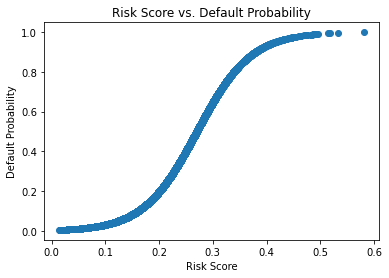

In [18]:
np.random.seed(42)  # for reproducibility

# Example parameters after inspecting the distribution
slope = -20  # Adjusted based on the new understanding of the risk score spread
midpoint = 0.27  # Adjusted to the median of risk scores if necessar

# Calculate Default Probability using a logistic function
df['Default_Probability'] = 1 / (1 + np.exp(slope * (df['Risk_Score'] - midpoint)))

# Assign Default based on calculated probabilities
df['Default'] = np.random.binomial(1, df['Default_Probability'])

# Print results
num_defaults = df['Default'].sum()
default_rate = num_defaults / len(df)
print(f"Number of defaults: {num_defaults}")
print(f"Default rate: {default_rate:.2%}")

# Plotting for visualization
import matplotlib.pyplot as plt
plt.scatter(df['Risk_Score'], df['Default_Probability'])
plt.title('Risk Score vs. Default Probability')
plt.xlabel('Risk Score')
plt.ylabel('Default Probability')
plt.show()


_Graph 1: Risk Score vs. Default Probability. For each data point, risk score is set as the mean of normalized Credit_Score, Debt_to_Income, and Loan_Amount, and Default Probability is defined as a logistic function of Risk Score, with triangulated slope and median to reach ~15% default rate for this dataset._